***This case study analyzes data provided by Starbucks that simulates their customer demographics and transactional activities during a promotional campaign. The campaign lasted for one month, during which customers received a variety of offers. The purpose of this case study is to understand customer response to different offers in order to come up with better approaches to sending customers specific promotional deals. Customers are classified into segments based on their transactional activities so that specific recommendations can be given regarding individual segments to improve customer stickiness, band rand awareness and increase revenue in general. Customer segmentation also provides insights on new customer targeting.***

***Business Questions  
I. What are better approaches to sending customer offers  
II. What are recommended strategies regarding specific customer group***s?

### Overview
During the campaign, 17,000 customers received offers through various channels. Customers received between 0 to 5 offers, and data includes their age, gender, income, and membership start date.

### Events
Customer interactions were recorded as:  
***Offer Events***: Received, Viewed, Completed  
***Transactions***: Purchases made  
Events are timestamped in hours since the campaign started.

### Methodology
***Data Wrangling***: Cleaned and transformed data across three Pandas DataFrames.

***Exploratory Data Analysis (EDA):***

***Univariate***: Summarized statistics for offers, demographics, and events.  
***Bivariate***: Analyzed relationships between demographics and customer behavior.  
***Offer Popularity***:  
***View Rate***: Views / Received offers  
***Completion Rate***: Completions / Views  
Identified key factors affecting offer performance.

### Customer Segmentation:

Used KMeans Clustering (k=5) based on offer views, completions, transactions, and spending.  
***Segments***: Most Valuable Customers, Regulars, High-potentials, Offer-Viewers, Low-engagers.

In [228]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from string import ascii_uppercase

In [229]:
df_offer = pd.read_csv('portfolio.csv')
df_customer = pd.read_csv('profile.csv')
df_transcript = pd.read_csv('transcript.csv')

In [230]:
df_offer = df_offer.drop('Unnamed: 0', axis = 1)
df_customer = df_customer.drop('Unnamed: 0', axis = 1)
df_transcript = df_transcript.drop('Unnamed: 0', axis = 1)

In [231]:
df_offer.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [232]:
df_customer.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [233]:
df_transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [234]:
missing_gender = df_customer[df_customer['gender'].isna()]
missing_income = df_customer[df_customer['income'].isna()]

In [235]:
np.sum(missing_gender['id'] == missing_income['id'])

2175

In [236]:
id_to_remove = missing_income['id']
df_customer_no_na = df_customer[~df_customer['id'].isin(id_to_remove)]
df_customer_no_na = df_customer_no_na.reset_index(drop = True)
df_customer_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [237]:
df_customer_no_na['became_member_on'] = pd.to_datetime(df_customer_no_na['became_member_on'], format = '%Y%m%d')

In [238]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [239]:
df_transcript.rename(columns = {'time' : 'hours_since_start'}, inplace = True)

In [240]:
df_offer = df_offer.sort_values(['offer_type', 'difficulty']).reset_index(drop = True)
df_offer['offer_alias'] = [ascii_uppercase[i] for i in range(df_offer.shape[0])]
df_offer

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,A
1,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,B
2,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,C
3,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E
5,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,F
6,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,G
7,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,H
8,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,I
9,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,J


In [241]:
value_column = df_transcript['value']
value_column = value_column.apply(eval)
value_column[:3]

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
Name: value, dtype: object

In [242]:
dictionary_key_column = [list(d.keys())[0] for d in value_column]
dictionary_value_column = [list(d.values())[0] for d in value_column]
value_column_split = pd.DataFrame(columns = ['dict_key', 'dict_value'])
value_column_split['dict_key'] = dictionary_key_column
value_column_split['dict_value'] = dictionary_value_column
value_column_split.head(3)

,dict_key,dict_value
0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer id,2906b810c7d4411798c6938adc9daaa5


In [243]:
df_transcript_value_mod = df_transcript.drop('value', axis = 1)
df_transcript_value_mod = pd.concat([df_transcript_value_mod, value_column_split], axis = 1)

In [244]:
col_names = ['person', 'event', 'dict_key', 'dict_value', 'hours_since_start']
df_transcript_value_mod = df_transcript_value_mod[col_names]

In [245]:
offers = df_offer.copy()
customers = df_customer_no_na.copy()
transcripts = df_transcript_value_mod.copy()

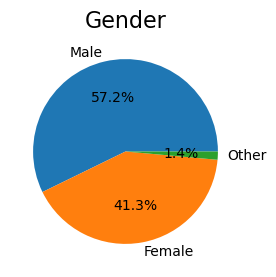

In [246]:
wedge_size =  df_customer_no_na['gender'].value_counts()
wedge_label = ['Male', 'Female', 'Other']
plt.figure(figsize = (3,3))
plt.pie(x = wedge_size, labels = wedge_label, autopct = '%1.1f%%')
plt.title('Gender', fontsize = 16)
plt.show()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


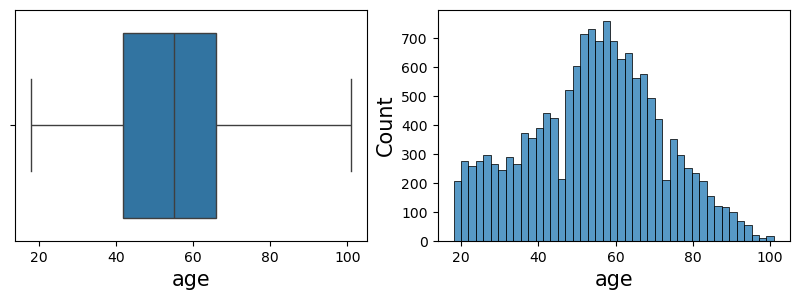

In [247]:
fig, axs = plt.subplots(1,2, figsize = (10,3))
sns.boxplot(data = customers, x = 'age', ax = axs[0])
sns.histplot(data = customers, x = 'age', ax = axs[1])
axs[0].xaxis.label.set_size(15)
axs[1].xaxis.label.set_size(15)
axs[1].yaxis.label.set_size(15)

print(customers['age'].describe())

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\1417227586.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  str(age_group_percentage[i]) + '%',


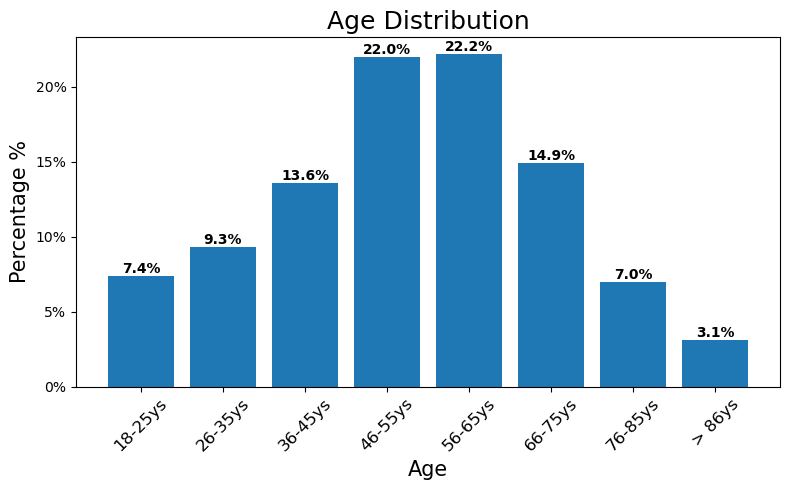

In [248]:
age_group = pd.cut(customers['age'],
      bins = [customers['age'].min(), 26, 36, 46, 56, 66, 76, 86, customers['age'].max()],
      labels = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys'])
customers['age_group'] = age_group

age_group_percentage = (customers.value_counts('age_group').sort_index() / customers.shape[0] * 100).round(1)
plt.figure(figsize = (8, 5))
yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = yticklabels)
plt.xticks(rotation = 45, fontsize = 12)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Percentage %', fontsize = 15)
plt.title('Age Distribution', fontsize = 18)

bar_plot = plt.bar(x = age_group_percentage.index.values, height = age_group_percentage)
for i,bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(age_group_percentage[i]) + '%',
            ha = 'center', weight = 'bold')

plt.tight_layout()
plt.show()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


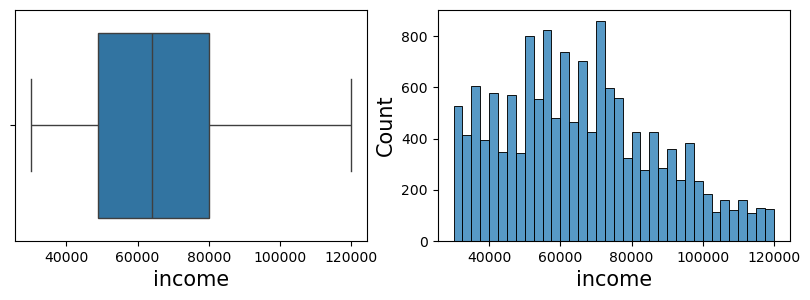

In [249]:
fig, axs = plt.subplots(1,2, figsize = (10,3))
sns.boxplot(data = customers, x = 'income', ax = axs[0])
sns.histplot(data = customers, x = 'income', ax = axs[1])
axs[0].xaxis.label.set_size(15)
axs[1].xaxis.label.set_size(15)
axs[1].yaxis.label.set_size(15)

print(customers['income'].describe())

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\1904374849.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  str(income_group_percentage[i]) + '%',


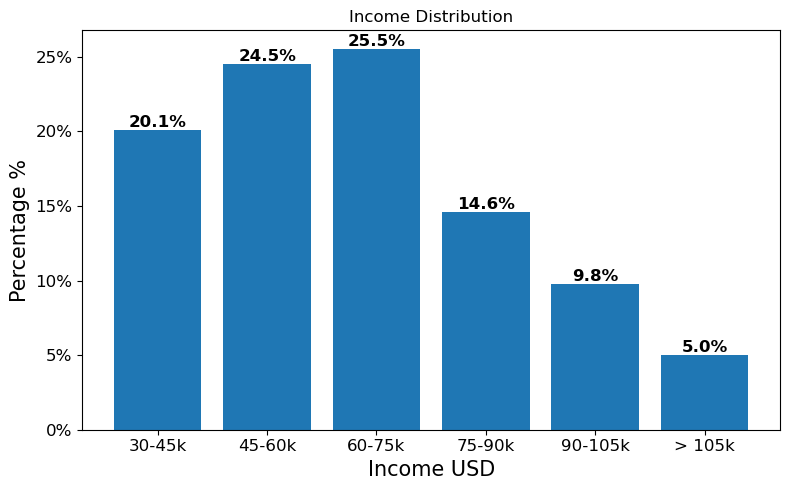

In [250]:
income_group = pd.cut(customers['income'],
      bins = [customers['income'].min(), 45000, 60000, 75000, 90000, 105000, customers['income'].max()],
      labels = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k'])
customers['income_group'] = income_group

income_group_percentage = (customers.value_counts('income_group').sort_index() / customers.shape[0] * 100).round(1)
plt.figure(figsize = (8, 5))
yticks = np.arange(0,30,5)
yticklabels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = yticklabels, fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Income USD', fontsize = 15)
plt.ylabel('Percentage %', fontsize = 15)
plt.title('Income Distribution')

bar_plot = plt.bar(x = income_group_percentage.index.values, height = income_group_percentage)
for i,bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(income_group_percentage[i]) + '%',
            ha = 'center', weight = 'bold', fontsize = 12)

plt.tight_layout()
plt.show()

In [251]:
df_member = customers[['id', 'became_member_on']]
df_member = df_member.assign(year = df_member.became_member_on.dt.year,
                             month = df_member.became_member_on.dt.month,
                             day = df_member.became_member_on.dt.day,
                             month_name = df_member.became_member_on.dt.month_name(),
                             day_of_week = df_member.became_member_on.dt.weekday,
                             day_name = df_member.became_member_on.dt.day_name())
df_member.head(3)

,id,became_member_on,year,month,day,month_name,day_of_week,day_name
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,7,15,July,5,Saturday
1,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,2017,5,9,May,1,Tuesday
2,e2127556f4f64592b11af22de27a7932,2018-04-26,2018,4,26,April,3,Thursday


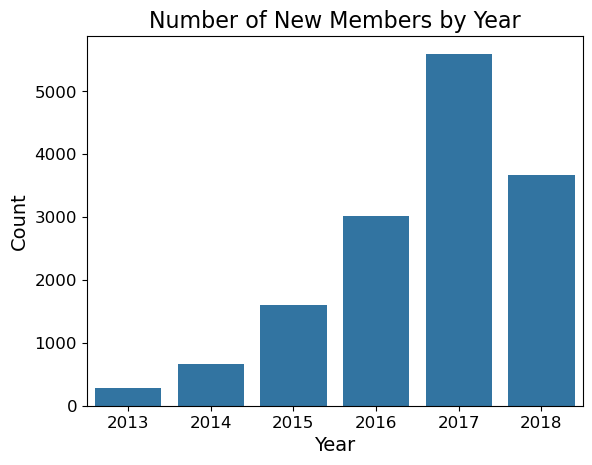

In [252]:
sns.countplot(data = df_member, x = 'year')
plt.title('Number of New Members by Year', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Year', fontsize = 14); plt.ylabel('Count', fontsize = 14)
plt.show()

In [253]:
p = df_member.value_counts('became_member_on').sort_index()
df_member_growth = pd.DataFrame(index = p.index.values, data = p.values, columns = ['Number of New Members'])

In [254]:
phase_1 = df_member_growth.loc['2013-july': '2015-july']
len_phase_1 = phase_1.shape[0]
mean_phase_1 = phase_1.mean().values

phase_2 = df_member_growth.loc['2015-august': '2017-july']
len_phase_2 = phase_2.shape[0]
mean_phase_2 = phase_2.mean().values

phase_3 = df_member_growth.loc['2017-august': '2018-jan']
len_phase_3 = phase_3.shape[0]
mean_phase_3 = phase_3.mean().values

phase_4 = df_member_growth.loc['2018-feb': '2018-july']
len_phase_4 = phase_4.shape[0]
mean_phase_4 = phase_4.mean().values

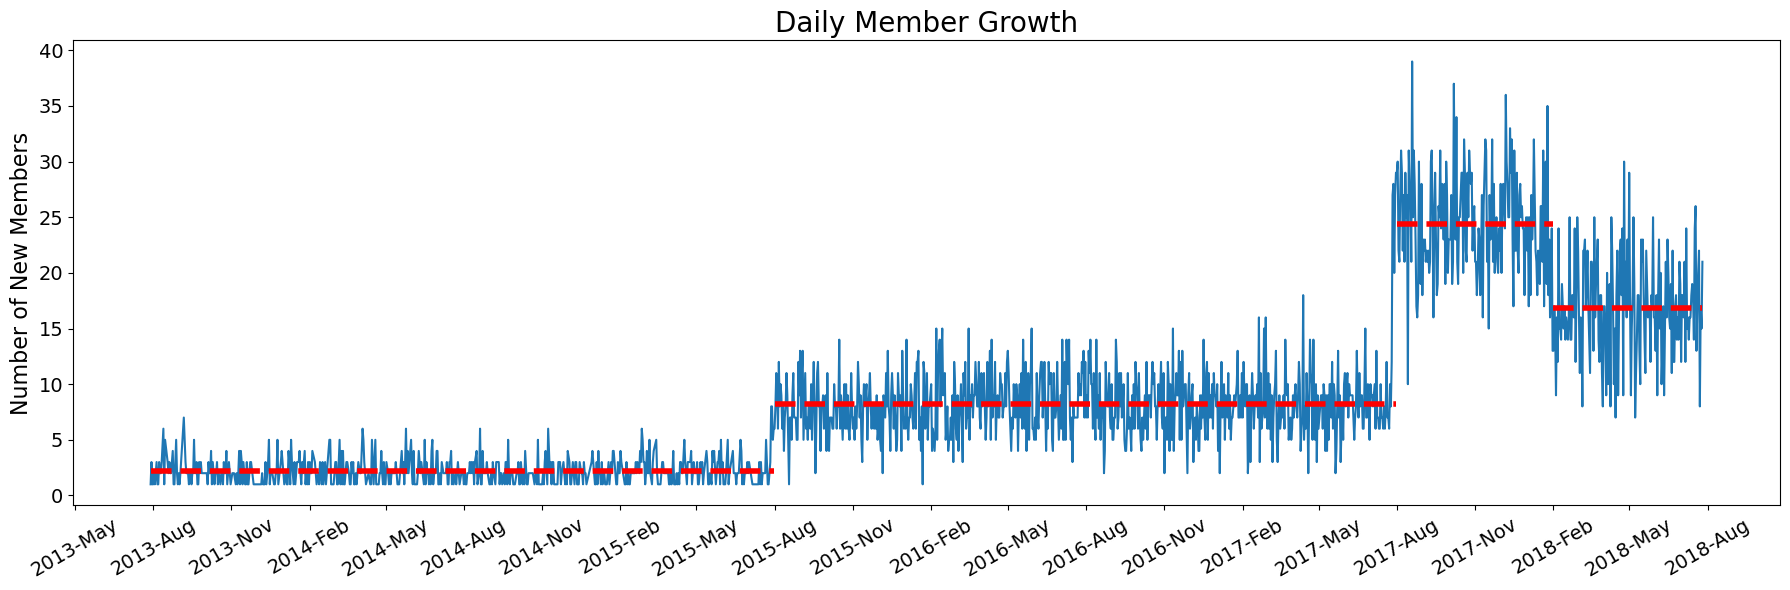

In [255]:
plt.figure(figsize = (18,6))
ax = sns.lineplot(x = df_member_growth.index.values, y = df_member_growth['Number of New Members'])
date_format = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))

plt.plot(phase_1.index.values, np.ones(len_phase_1)*mean_phase_1, '--r', lw = 4)
plt.plot(phase_2.index.values, np.ones(len_phase_2)*mean_phase_2, '--r', lw = 4)
plt.plot(phase_3.index.values, np.ones(len_phase_3)*mean_phase_3, '--r', lw = 4)
plt.plot(phase_4.index.values, np.ones(len_phase_4)*mean_phase_4, '--r', lw = 4)

plt.xticks(text = ax.xaxis.get_label(), fontsize = 14, rotation = 30)
plt.yticks(text = ax.yaxis.get_label(), fontsize = 14)
plt.ylabel('Number of New Members', fontsize = 16)
plt.title('Daily Member Growth', fontsize = 20)
plt.tight_layout()
plt.show()

              age
gender           
F       57.544950
M       52.116690
O       54.400943


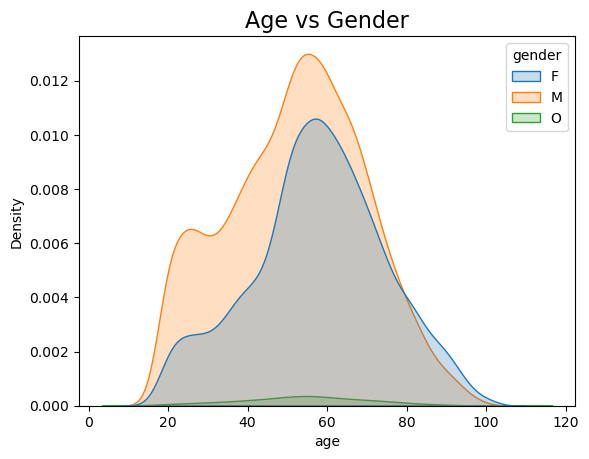

In [256]:
print(customers.groupby('gender').agg({'age': 'mean'}))
sns.kdeplot(data = customers, x = 'age', hue = 'gender', fill = True)
plt.title('Age vs Gender', fontsize = 16)
plt.show()

              income
gender              
F       71306.412139
M       61194.601603
O       63287.735849


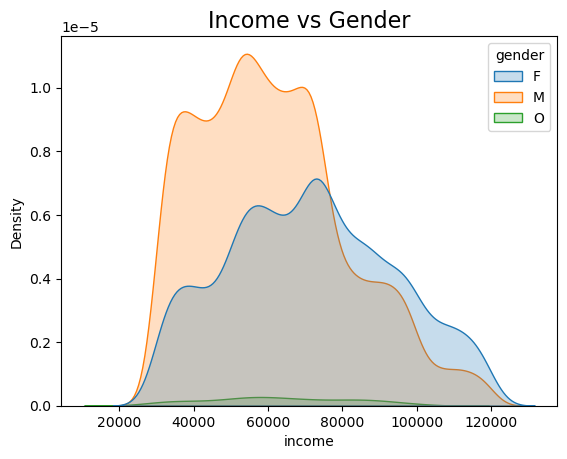

In [257]:
print(customers.groupby('gender').agg({'income': 'mean'}))
sns.kdeplot(data = customers, x = 'income', hue = 'gender', fill = True)
plt.title('Income vs Gender', fontsize = 16)
plt.show()

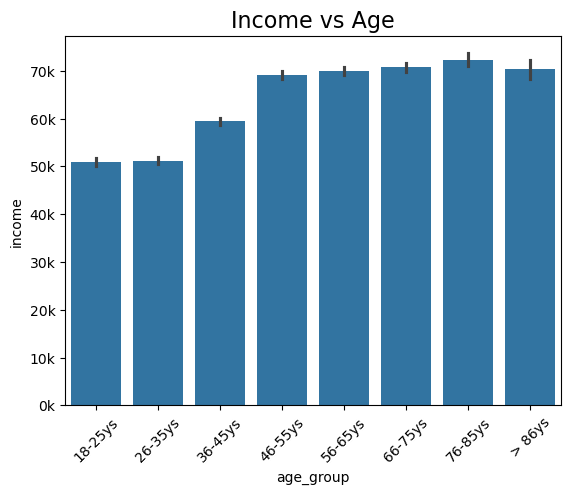

In [258]:
sns.barplot(data = customers, x = 'age_group', y = 'income')
plt.xticks(rotation = 45)
ytick_labels = [str(i) + 'k' for i in (np.arange(0, 80000, 10000) / 1000).astype(int)]
plt.yticks(np.arange(0, 80000, 10000), labels = ytick_labels)
plt.title('Income vs Age', fontsize = 16)
plt.show()

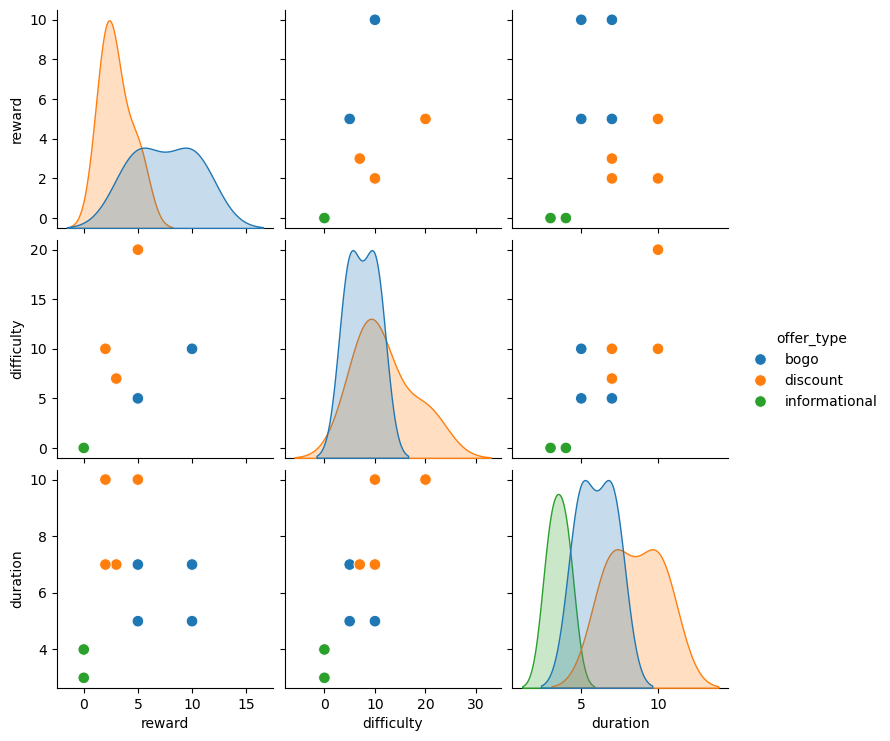

In [259]:
sns.pairplot(offers, hue = 'offer_type', 
             plot_kws = dict(marker="o", s=70),); plt.show()

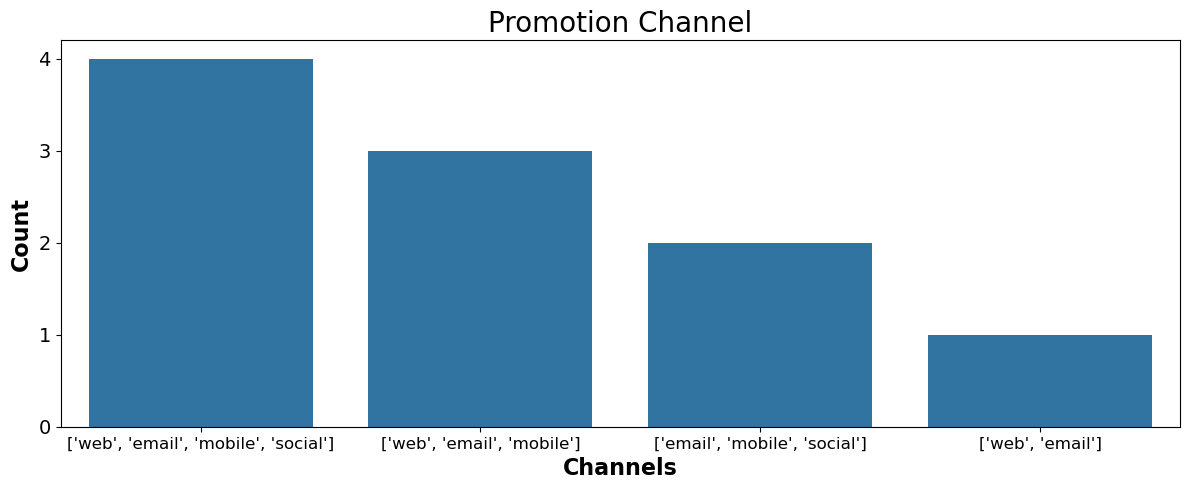

In [260]:
p = offers.value_counts('channels')
plt.figure(figsize = (12,5))
sns.barplot(x = p.index.values, y = p.values)
plt.xticks(rotation = None, fontsize = 12)
plt.yticks(np.arange(5), fontsize = 14)
plt.xlabel('Channels', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.title('Promotion Channel', fontsize = 20)
plt.tight_layout()
plt.show()

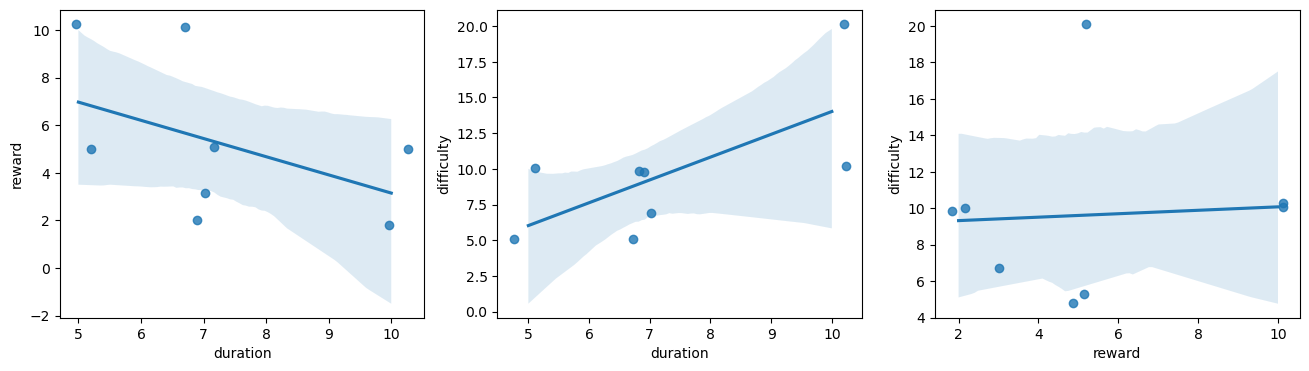

In [261]:
fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.regplot(data = offers[0:8], x = 'duration', y ='reward', x_jitter = 0.3, y_jitter = 0.3, ax = axs[0])
sns.regplot(data = offers[0:8], x = 'duration', y ='difficulty', x_jitter = 0.3, y_jitter = 0.3, ax = axs[1])
sns.regplot(data = offers[0:8], x = 'reward', y ='difficulty', x_jitter = 0.3, y_jitter = 0.3, ax = axs[2])
plt.show()

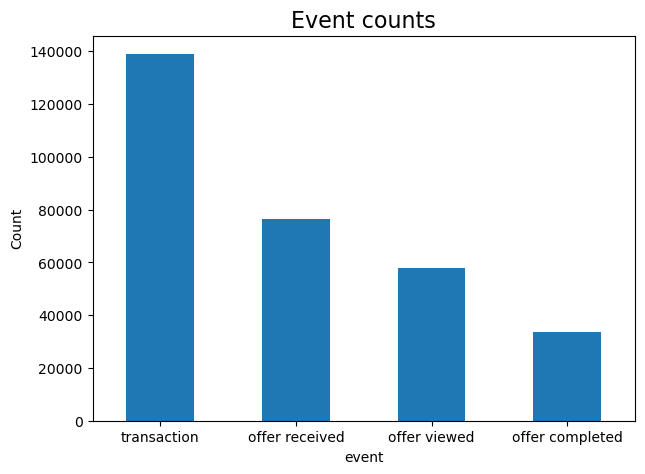

In [262]:
fig = plt.figure(figsize = (7,5))
transcripts['event'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Event counts', fontsize = 16)
plt.show()

In [263]:
transcripts = transcripts.assign(days_since_start = transcripts['hours_since_start']/24).astype({'days_since_start': 'int64'})
print('The minimum and the maximum of column days_since_start: {} and {}'.format(transcripts['days_since_start'].min(), transcripts['days_since_start'].max()))

The minimum and the maximum of column days_since_start: 0 and 29


In [264]:
transcripts[transcripts['event'] == 'offer received'].groupby('hours_since_start').count()

,person,event,dict_key,dict_value,days_since_start
hours_since_start,,,,,
0,12650,12650,12650,12650,12650
168,12669,12669,12669,12669,12669
336,12711,12711,12711,12711,12711
408,12778,12778,12778,12778,12778
504,12704,12704,12704,12704,12704
576,12765,12765,12765,12765,12765


In [265]:
viewed_hourly = transcripts[transcripts['event'] == 'offer viewed'].value_counts('hours_since_start').sort_index()
completed_hourly = transcripts[transcripts['event'] == 'offer completed'].value_counts('hours_since_start').sort_index()
transaction_hourly = transcripts[transcripts['event'] == 'transaction'].value_counts('hours_since_start').sort_index()
print(len(viewed_hourly), len(completed_hourly), len(transaction_hourly))

120 120 120


In [266]:
(viewed_hourly.index.values == completed_hourly.index.values).sum(), (completed_hourly.index.values == transaction_hourly.index.values).sum()

(120, 120)

In [267]:
received_daily = transcripts[transcripts['event'] == 'offer received'].value_counts('days_since_start').sort_index()
viewed_daily = transcripts[transcripts['event'] == 'offer viewed'].value_counts('days_since_start').sort_index()
completed_daily = transcripts[transcripts['event'] == 'offer completed'].value_counts('days_since_start').sort_index()
transaction_daily = transcripts[transcripts['event'] == 'transaction'].value_counts('days_since_start').sort_index()

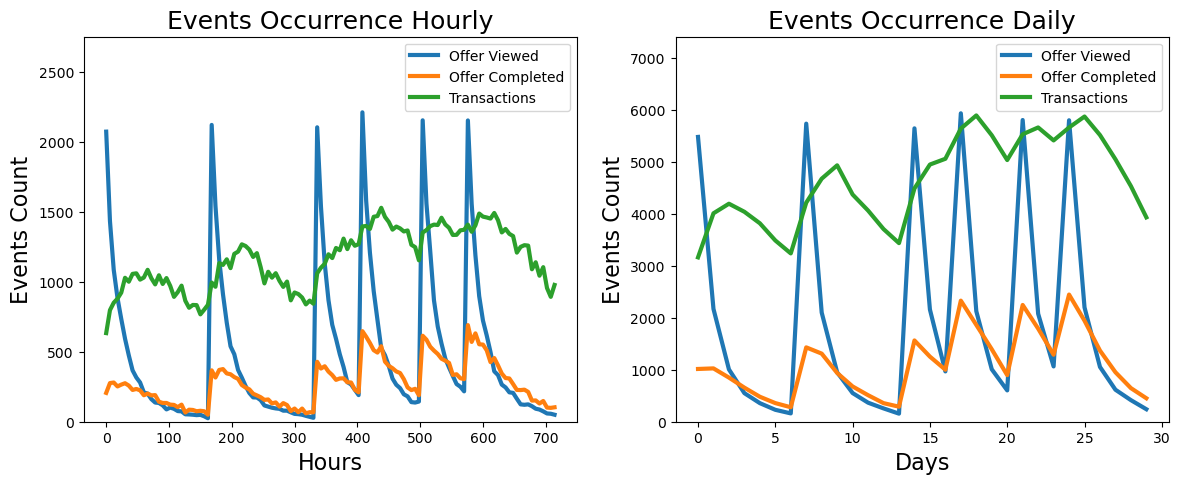

In [268]:
hours = viewed_hourly.index.values
fig, axs = plt.subplots(1,2, figsize = (14, 5))
axs[0].plot(hours, viewed_hourly, lw = 3)
axs[0].plot(hours, completed_hourly, lw = 3)
axs[0].plot(hours, transaction_hourly, lw = 3)
axs[0].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)
axs[0].set_ylim([0, 2750])
axs[0].set_xlabel('Hours', fontsize = 16)
axs[0].set_ylabel('Events Count', fontsize = 16)
axs[0].set_title('Events Occurrence Hourly', fontsize = 18)

days = np.arange(30)
axs[1].plot(days, viewed_daily, lw = 3)
axs[1].plot(days, completed_daily, lw = 3)
axs[1].plot(days, transaction_daily, lw = 3)
axs[1].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)
axs[1].set_ylim([0, 7400])
axs[1].set_xlabel('Days', fontsize = 16)
axs[1].set_ylabel('Events Count', fontsize = 16)
axs[1].set_title('Events Occurrence Daily', fontsize = 18)

plt.show()

In [269]:
df_event = transcripts[~(transcripts['event'] == 'transaction')]
event_offer = pd.merge(df_event, offers, left_on = 'dict_value', right_on = 'id').drop('id', axis = 1)
col_names = ['person', 'event', 'offer_alias', 'reward',
       'channels', 'difficulty', 'duration', 'offer_type', 'hours_since_start', 'days_since_start', 'dict_key', 'dict_value',]
event_offer = event_offer[col_names]
event_offer = event_offer.drop('dict_value', axis = 1)
event_offer.sample(3)

,person,event,offer_alias,reward,channels,difficulty,duration,offer_type,hours_since_start,days_since_start,dict_key
116768,7fb6bf3c081b41ceb3609d53c87110d7,offer received,D,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,504,21,offer id
166190,60342056f16c4bebb9e7bc1565b5abb4,offer completed,C,10,"['email', 'mobile', 'social']",10,7,bogo,678,28,offer_id
155198,d00beaf31d7d4811a9f9be1556c2070d,offer completed,B,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,588,24,offer_id


In [270]:
offer_received = event_offer[event_offer['event'] == 'offer received']
p0 = offer_received.value_counts('offer_alias').sort_values(ascending = False)
offer_completed = event_offer[event_offer['event'] == 'offer completed']
p2 = offer_completed.value_counts('offer_alias').sort_values(ascending = False)

In [271]:
overall_complete_rate = (p2.sort_index() / p0.sort_index()).sort_values(ascending = False)

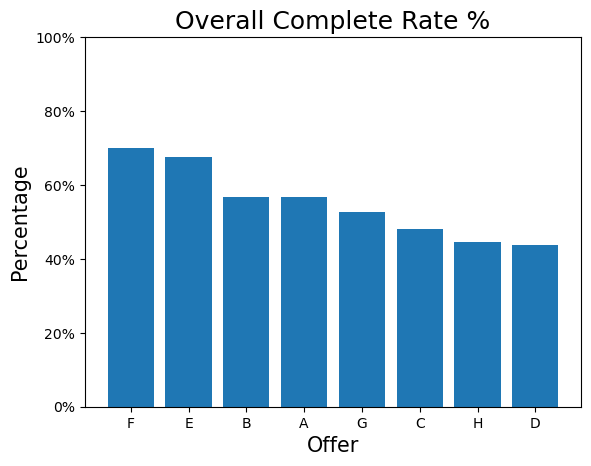

In [272]:
plt.bar(x = overall_complete_rate.index.values, height = overall_complete_rate.values)
plt.title('Overall Complete Rate %', fontsize = 18)
plt.xlabel('Offer', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.yticks(np.arange(0,1.2, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

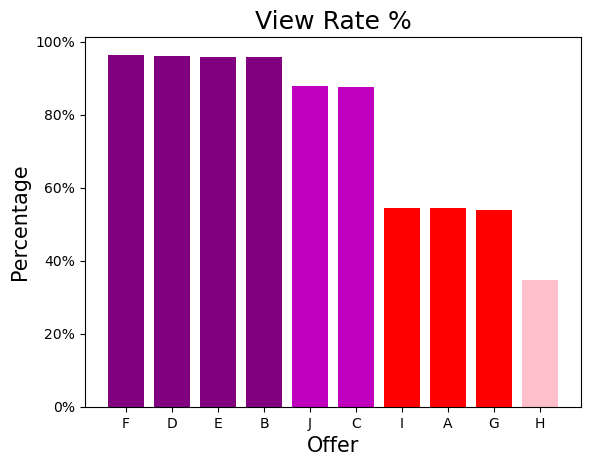

In [273]:
offer_viewed = event_offer[event_offer['event'] == 'offer viewed']
p1 = offer_viewed.value_counts('offer_alias').sort_values(ascending = False)
p1_rate = (p1.sort_index() / p0.sort_index()).sort_values(ascending = False)
plt.bar(x = np.arange(len(p1)), height = p1_rate.values, tick_label = p1_rate.index.values,
       color = ['purple', 'purple','purple', 'purple', 'm', 'm','r', 'r', 'r', 'pink'])
plt.title('View Rate %', fontsize = 18)
plt.xlabel('Offer', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.yticks(np.arange(0,1.2, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

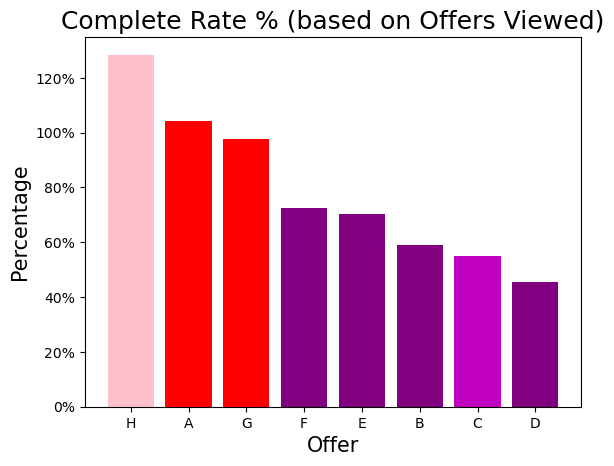

In [274]:
p2 = offer_completed.value_counts('offer_alias').sort_values(ascending = False)

p2_rate = (p2.sort_index() / p1.sort_index()).sort_values(ascending = False)
color_list = ['pink', 'red', 'red', 'purple', 'purple', 'purple', 'm', 'purple']
plt.bar(x = p2_rate.index.values, height = p2_rate.values, color = color_list)
plt.title('Complete Rate % (based on Offers Viewed)', fontsize = 18)
plt.xlabel('Offer', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.yticks(np.arange(0,1.4, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%', '120%'])
plt.show()

In [275]:
offers_added = offers.assign(view_rate = p1_rate.sort_index().values,
                            complete_rate = p2_rate.sort_index().values)
offers_added.set_index('offer_alias', inplace = True)
offers_numeric = offers_added.select_dtypes(include = 'number')
offers_numeric

,reward,difficulty,duration,view_rate,complete_rate
offer_alias,,,,,
A,5,5,7,0.543311,1.043874
B,5,5,5,0.959451,0.591410
C,10,10,7,0.876991,0.549136
D,10,10,5,0.961148,0.456426
E,3,7,7,0.959587,0.702740
F,2,10,10,0.964460,0.725672
G,2,10,7,0.539570,0.975474
H,5,20,10,0.347287,1.284266
I,0,0,4,0.544046,NaN


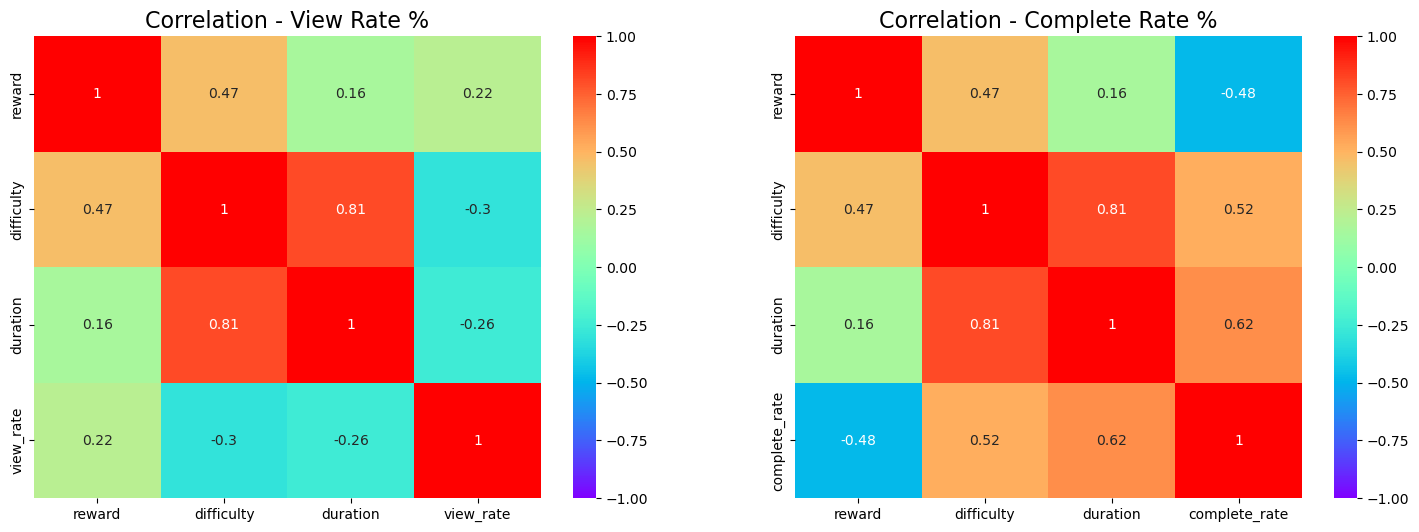

In [276]:
fig, axs = plt.subplots(1,2, figsize = (18, 6))
sns.heatmap(offers_numeric.iloc[:, :-1].corr(), cmap = 'rainbow', 
            annot = True, vmin = -1, vmax = 1, ax = axs[0])
axs[0].set_title('Correlation - View Rate %', fontsize = 16)

sns.heatmap(offers_numeric.iloc[:, [0,1,2,4]].corr(), cmap = 'rainbow', 
            annot = True, vmin = -1, vmax = 1, ax = axs[1])
axs[1].set_title('Correlation - Complete Rate %', fontsize = 16)
plt.show()

In [277]:
customer_behavior = pd.DataFrame(columns = ['person', 'num_received', 'num_viewed', 'num_completed', 'num_transactions', 'money_spent'])

In [278]:
id_to_remove = missing_income['id']
transcripts_filtered = transcripts[~transcripts['person'].isin(id_to_remove)].reset_index(drop = True)
customer_behavior['person'] = transcripts_filtered.value_counts('person').sort_index().index.values

In [279]:
transcripts_filtered = transcripts_filtered.sort_values('person')
transcripts_grouped = transcripts_filtered.groupby(['person', 'event']).count()
transcripts_grouped.head()

dict_key  dict_value  \
person                           event                                   
0009655768c64bdeb2e877511632db8f offer completed         3           3   
                                 offer received          5           5   
                                 offer viewed            4           4   
                                 transaction             8           8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed         3           3   

                                                  hours_since_start  \
person                           event                                
0009655768c64bdeb2e877511632db8f offer completed                  3   
                                 offer received                   5   
                                 offer viewed                     4   
                                 transaction                      8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed                  3   

                                                  days_since_start  
person                           event                              
0009655768c64bdeb2e877511632db8f offer completed                 3  
                                 offer received                  5  
                                 offer viewed                    4  
                                 transaction                     8  
0011e0d4e6b944f998e987f904e8c1e5 offer completed                 3

In [280]:
customer_behavior.set_index('person', inplace = True)
for person_id in customer_behavior.index.values:
    if (person_id, 'offer received') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_received'] = transcripts_grouped.loc[(person_id, 'offer received'), 'dict_key']
    if (person_id, 'offer viewed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_viewed'] = transcripts_grouped.loc[(person_id, 'offer viewed'), 'dict_key']
    if (person_id, 'offer completed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_completed'] = transcripts_grouped.loc[(person_id, 'offer completed'), 'dict_key']
    if (person_id, 'transaction') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_transactions'] = transcripts_grouped.loc[(person_id, 'transaction'), 'dict_key']

In [281]:
money_spent = transcripts_filtered[transcripts_filtered['event'] == 'transaction'].groupby('person').agg({'dict_value': 'sum'})
customer_behavior['money_spent'] = money_spent
customer_behavior.head(3)

,num_received,num_viewed,num_completed,num_transactions,money_spent
person,,,,,
0009655768c64bdeb2e877511632db8f,5,4,3,8,127.6
0011e0d4e6b944f998e987f904e8c1e5,5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,5,3,3,8,196.86


In [282]:
customer_behavior.fillna(0, inplace = True)
customer_behavior.isna().sum()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\3938726843.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_behavior.fillna(0, inplace = True)


num_received        0
num_viewed          0
num_completed       0
num_transactions    0
money_spent         0
dtype: int64

In [283]:
customer_behavior_with_num_received = customer_behavior.copy()
customer_behavior.drop('num_received', axis = 1, inplace = True)
customer_behavior.head(3)

,num_viewed,num_completed,num_transactions,money_spent
person,,,,
0009655768c64bdeb2e877511632db8f,4,3,8,127.60
0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86


In [284]:
customer_behavior['money_spent'].describe()

count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: money_spent, dtype: float64

In [285]:
# Remove rows with top 2% in `money_spent`
q = customer_behavior['money_spent'].quantile(0.98)
rows_top_money_spent = customer_behavior[customer_behavior['money_spent'] >= q]

person_top_money_spent = rows_top_money_spent.index.values
customer_top_money_spent_removed = customer_behavior[customer_behavior['money_spent'] < q]

print('Number of rows removed:', rows_top_money_spent.shape[0])

Number of rows removed: 297


In [286]:
customer_behavior_filtered = customer_top_money_spent_removed.copy()

In [287]:
scaler_customer_behavior = StandardScaler()
scaler_customer_behavior.fit(customer_behavior_filtered)
customer_behavior_scaled = scaler_customer_behavior.transform(customer_behavior_filtered)
pd.DataFrame(data = customer_behavior_scaled, columns = customer_behavior_filtered.columns.values).head(3)

,num_viewed,num_completed,num_transactions,money_spent
0,0.501233,0.531352,-0.060069,0.277234
1,1.276977,0.531352,-0.639666,-0.281415
2,-0.274511,0.531352,-0.060069,1.080974


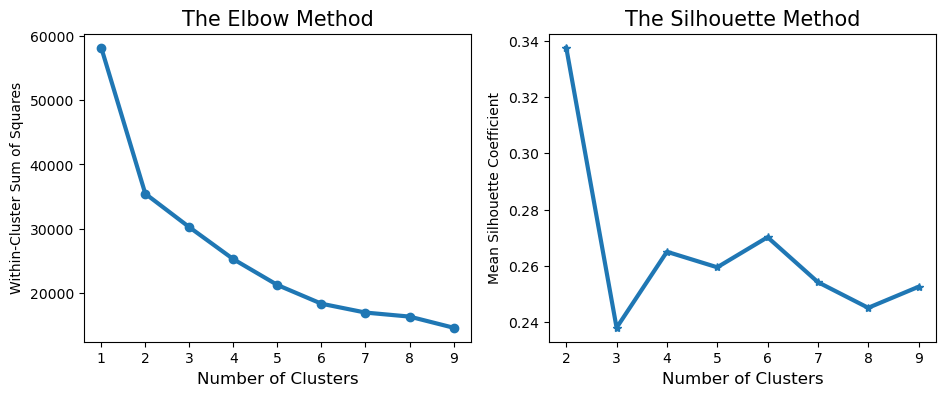

In [288]:
df_feature = customer_behavior_scaled
wcss = []
sil_score = []
max_clusters = 10

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 10)
    kmeans.fit(df_feature)
    # calculate wcss for the Elbow Method
    wcss.append(kmeans.inertia_)
    
    # calculate the mean Silhouette coefficient
    if k >= 2:
        labels = kmeans.labels_
        sil_score.append(metrics.silhouette_score(df_feature, labels))

        # Plot
fig, axs = plt.subplots(1,2, figsize = (11,4))
axs[0].plot(np.arange(1, max_clusters), wcss, marker = 'o', lw = 3)
axs[0].set_xlabel('Number of Clusters', fontsize = 12)
axs[0].set_ylabel('Within-Cluster Sum of Squares')
axs[0].set_title('The Elbow Method', fontsize = 15)

axs[1].plot(np.arange(2, max_clusters), sil_score, marker = '*' , lw = 3)
axs[1].set_xlabel('Number of Clusters', fontsize = 12)
axs[1].set_ylabel('Mean Silhouette Coefficient')
axs[1].set_title('The Silhouette Method', fontsize = 15)
plt.show()

cluster
0    2848
1    1720
2    4063
3    3480
4    2417
Name: count, dtype: int64

 ************************************************************
Silhouette Score: 0.25952377980287417

 ************************************************************
        num_viewed num_completed num_transactions money_spent
              mean          mean             mean        mean
cluster                                                      
0              1.6           0.9              5.3        50.1
1              3.4           2.0             16.7        74.3
2              3.7           3.2              7.3       129.8
3              3.8           0.8              4.4        33.8
4              4.2           4.1             13.2       244.7


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\3367152633.py:13: FutureWarning: The provided callable <function mean at 0x00000196DE00AAC0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cluster_info = customer_with_cluster.groupby('cluster').agg([np.mean])


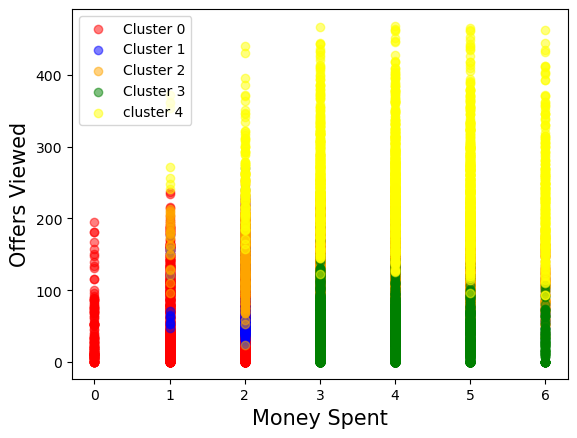

In [289]:
k = 5
df_feature = customer_behavior_scaled
kmeans = KMeans(n_clusters = k, random_state = 10)
kmeans.fit_transform(df_feature)
customer_with_cluster = customer_behavior_filtered.assign(cluster = kmeans.labels_)
print(customer_with_cluster.value_counts('cluster').sort_index())

line_sep = '*' * 60
print('\n', line_sep)
print('Silhouette Score:', metrics.silhouette_score(df_feature, labels = kmeans.labels_))

#
cluster_info = customer_with_cluster.groupby('cluster').agg([np.mean])
print('\n', line_sep)
print(cluster_info.round(1))

# Plot
color_list = ['red', 'blue', 'orange', 'green', 'yellow']
legend_list = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'cluster 4']
for i in range(k):
    plt.scatter(customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'num_viewed'],
               customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'money_spent'],
               c = color_list[i], label = legend_list[i], alpha = 0.5)
plt.ylabel('Offers Viewed', fontsize = 15)
plt.xlabel('Money Spent', fontsize = 15)
plt.legend(legend_list)
plt.show()

In [290]:
# Split data for train and test
X = customer_behavior_scaled
Y = customer_with_cluster['cluster']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [291]:
# Multiclass logistic regression
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Check test accurracy
y_predict = clf.predict(x_test)
print("Test accuracy:", metrics.accuracy_score(y_test, y_predict))

Test accuracy: 0.9979353062629044


In [292]:
# K-Nearest Neighbors Classificaiton
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(x_train, y_train)

# Check test accuracy
y_predict = knn.predict(x_test)
print("Test accuracy:", metrics.accuracy_score(y_test, y_predict))

Test accuracy: 0.9845147969717826


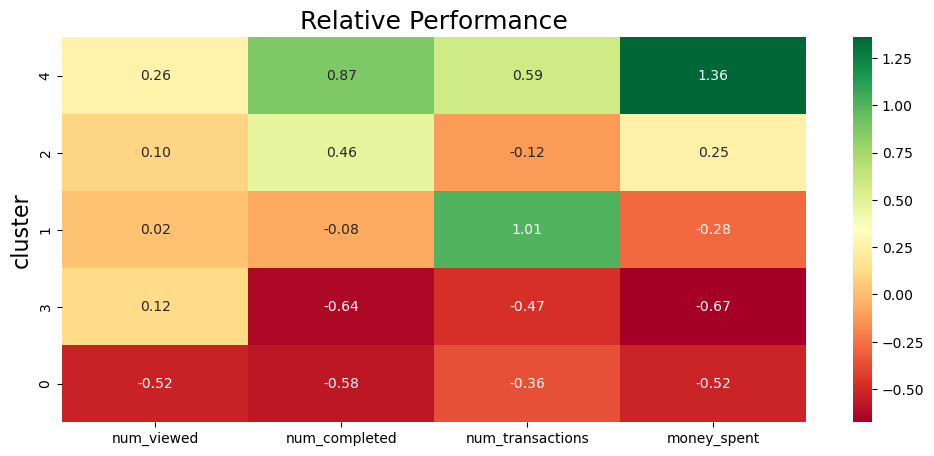

In [293]:
cluster_mean = customer_with_cluster.groupby('cluster').mean()
population_mean = customer_with_cluster.mean()
relative_importance = (cluster_mean / population_mean[0 :-1]) - 1
importance_ranking = relative_importance.sum(axis = 1).sort_values(ascending = False).index.values
relative_importance = relative_importance.reindex(importance_ranking)
plt.figure(figsize = (12, k))
plt.title('Relative Performance', fontsize = 18)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('Cluster', fontsize = 16)
sns.heatmap(data = relative_importance, annot = True, fmt = '.2f', cmap = 'RdYlGn')
plt.show()

In [294]:
temp = pd.merge(customer_with_cluster, customer_behavior_with_num_received['num_received'], left_index = True, right_index = True)
cluster_means = temp.groupby('cluster').mean().round(3)
cluster_means = cluster_means.reindex(importance_ranking)
cluster_means

,num_viewed,num_completed,num_transactions,money_spent,num_received
cluster,,,,,
4,4.232,4.051,13.201,244.716,4.986
2,3.681,3.161,7.308,129.777,4.597
1,3.427,1.998,16.690,74.312,4.605
3,3.767,0.784,4.373,33.770,4.641
0,1.593,0.918,5.342,50.071,3.619


In [295]:
cluster_summary = pd.DataFrame(columns = ['cluster', 'frequency', 'avg_purchase_value', 'offer_complete_rate', 'offer_sensitivity'])
cluster_summary['cluster'] = index = np.arange(k)
cluster_summary.set_index('cluster', drop = True, inplace = True)

In [296]:
cluster_summary['frequency'] = cluster_means['num_transactions'].round(1)
cluster_summary['avg_purchase_value'] = (cluster_means['money_spent'] / cluster_means['num_transactions']).round(1)
cluster_summary['offer_complete_rate'] = (cluster_means['num_completed'] / cluster_means['num_received']).round(2)
cluster_summary['offer_sensitivity'] = (cluster_means['num_completed'] / cluster_means['num_transactions']).round(2)

In [297]:
cluster_summary = cluster_summary.reindex(importance_ranking)
cluster_summary

,frequency,avg_purchase_value,offer_complete_rate,offer_sensitivity
cluster,,,,
4,13.2,18.5,0.81,0.31
2,7.3,17.8,0.69,0.43
1,16.7,4.5,0.43,0.12
3,4.4,7.7,0.17,0.18
0,5.3,9.4,0.25,0.17


In [298]:
rows_top_money_spent_scaled = scaler_customer_behavior.transform(rows_top_money_spent)
kmeans.predict(rows_top_money_spent_scaled)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [299]:
cluster_kmeans = kmeans.predict(rows_top_money_spent_scaled)
unique_element, counter = np.unique(cluster_kmeans, return_counts = True)

print('According to the KMeans model, customers spending top 2% belong to:')
for i in range(len(unique_element)):
    print('{} customers belongs to Cluster {}.'.format(counter[i], unique_element[i]))

According to the KMeans model, customers spending top 2% belong to:
297 customers belongs to Cluster 4.


In [300]:
cluster_logistic = clf.predict(rows_top_money_spent_scaled)
unique_element, counter = np.unique(cluster_logistic, return_counts = True)

print('According to the Logistic Regression model, customers spending top 2% belong to:')
for i in range(len(unique_element)):
    print('{} customers belongs to Cluster {}.'.format(counter[i], unique_element[i])) 

According to the Logistic Regression model, customers spending top 2% belong to:
297 customers belongs to Cluster 4.


In [301]:
cluster_KNN = knn.predict(rows_top_money_spent_scaled)
unique_element, counter = np.unique(cluster_KNN, return_counts = True)

print('According to the KNN model, customers spending top 2% belong to:')
for i in range(len(unique_element)):
    print('{} customers belongs to Cluster {}.'.format(counter[i], unique_element[i])) 

According to the KNN model, customers spending top 2% belong to:
297 customers belongs to Cluster 4.


In [302]:
# Concatenate top 2% spenders with the rest of the customers (behavior)
customer_behavior_clustered = temp[rows_top_money_spent.columns.values]
customer_behavior_clustered = customer_behavior_clustered.assign(cluster = temp['cluster'])
customer_behavior_clustered = pd.concat([customer_behavior_clustered, rows_top_money_spent], axis = 0)

# Assign these customers to cluster 1
customer_behavior_clustered.fillna(value = 1, inplace = True)

# Convert cluster label from float to integers
customer_behavior_clustered['cluster'] = customer_behavior_clustered['cluster'].astype('int')

In [303]:
# Reset index for `customer_behavior_clustered`
customer_behavior_clustered.reset_index(inplace = True)
# Merge
customer_behavior_profile = pd.merge(customer_behavior_clustered, customers,
                                    left_on = 'person', right_on = 'id').drop(['id'], axis = 1)

In [304]:
# Add column `cluster_alias`
customer_behavior_profile['cluster_alias'] = customer_behavior_profile['cluster'].map({4: 'Most-Valables',
                                                                                       2: 'Regulars',
                                                                                       1: 'High-Potentials',
                                                                                       3: 'Offer-Viewers',
                                                                                       0: 'Low-Engagers'})
customer_behavior_profile.head(3)

,person,num_viewed,num_completed,num_transactions,money_spent,cluster,gender,age,became_member_on,income,age_group,income_group,cluster_alias
0,0009655768c64bdeb2e877511632db8f,4,3,8,127.60,2,M,33,2017-04-21,72000.0,26-35ys,60-75k,Regulars
1,0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46,2,O,40,2018-01-09,57000.0,36-45ys,45-60k,Regulars
2,0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86,2,F,59,2016-03-04,90000.0,56-65ys,75-90k,Regulars


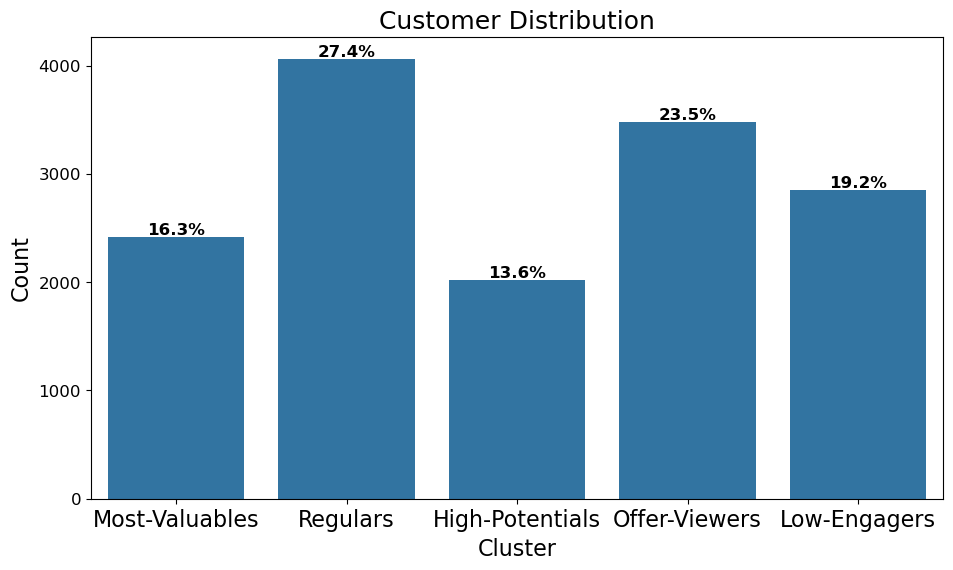

In [305]:
p = customer_behavior_profile.value_counts('cluster').reindex(importance_ranking)
cluster_pct = list((p/p.sum() * 100).round(2))
cluster_names = ['Most-Valuables','Regulars','High-Potentials','Offer-Viewers','Low-Engagers']
fig = plt.figure(figsize = (11,6))
ax = sns.barplot(x = p.index.values, y = p.values, order = importance_ranking)
patches = ax.patches
for i in range(len(p)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height() + 25
    ax.annotate(text = '{:.1f}%'.format(cluster_pct[i]), xy = (x, y), ha = 'center',
               fontsize = 12, weight = 'bold')
    
plt.title('Customer Distribution', fontsize = 18)
plt.xticks(ticks = np.arange(len(p)), labels = cluster_names, fontsize = 16)
plt.yticks(ticks = np.arange(0, 5000, 1000), fontsize = 12)
plt.xlabel('Cluster', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.show()

In [306]:
segment_means = customer_behavior_profile.groupby('cluster').agg({'age': 'mean', 'income': 'mean'}).reindex(importance_ranking)
segment_means.index = ['Most-Valuables','Regulars','High-Potentials','Offer-Viewers','Low-Engagers']
segment_means.round(2).head()

,age,income
Most-Valuables,55.65,72075.30
Regulars,58.01,73215.60
High-Potentials,48.88,52803.67
Offer-Viewers,53.47,61465.23
Low-Engagers,53.20,62339.89


In [307]:
event_offer['channel_alias'] = event_offer['channels'].map({
    "['web', 'email', 'mobile', 'social']": 1,
    "['email', 'mobile', 'social']": 2,
    "['web', 'email', 'mobile']": 3,
    "['web', 'email']": 4
})

In [308]:
# Merge
event_offer_customer = pd.merge(customers, event_offer, left_on = 'id', right_on = 'person').drop('id', axis = 1)

# Drop unwanted columns
event_offer_customer.drop(['channels', 'dict_key'], axis = 1, inplace = True)

# Reorder columns
col_names = ['gender', 'age', 'became_member_on', 'income', 'age_group', 'income_group', 'person', 
             'event', 'offer_alias', 'channel_alias', 'offer_type',
             'reward', 'difficulty', 'duration',
             'hours_since_start', 'days_since_start'
       ]
event_offer_customer = event_offer_customer[col_names]
event_offer_customer.head(3)

,gender,age,became_member_on,income,age_group,income_group,person,event,offer_alias,channel_alias,offer_type,reward,difficulty,duration,hours_since_start,days_since_start
0,F,55,2017-07-15,112000.0,46-55ys,> 105k,0610b486422d4921ae7d2bf64640c50b,offer received,A,3,bogo,5,5,7,408,17
1,F,55,2017-07-15,112000.0,46-55ys,> 105k,0610b486422d4921ae7d2bf64640c50b,offer received,I,3,informational,0,0,4,504,21
2,F,55,2017-07-15,112000.0,46-55ys,> 105k,0610b486422d4921ae7d2bf64640c50b,offer completed,A,3,bogo,5,5,7,528,22


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\2179888820.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  view_rate = [x[0] for x in view_rate]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\2179888820.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  complete_rate = [x[0] for x in complete_rate]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\2179888820.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  overall_com

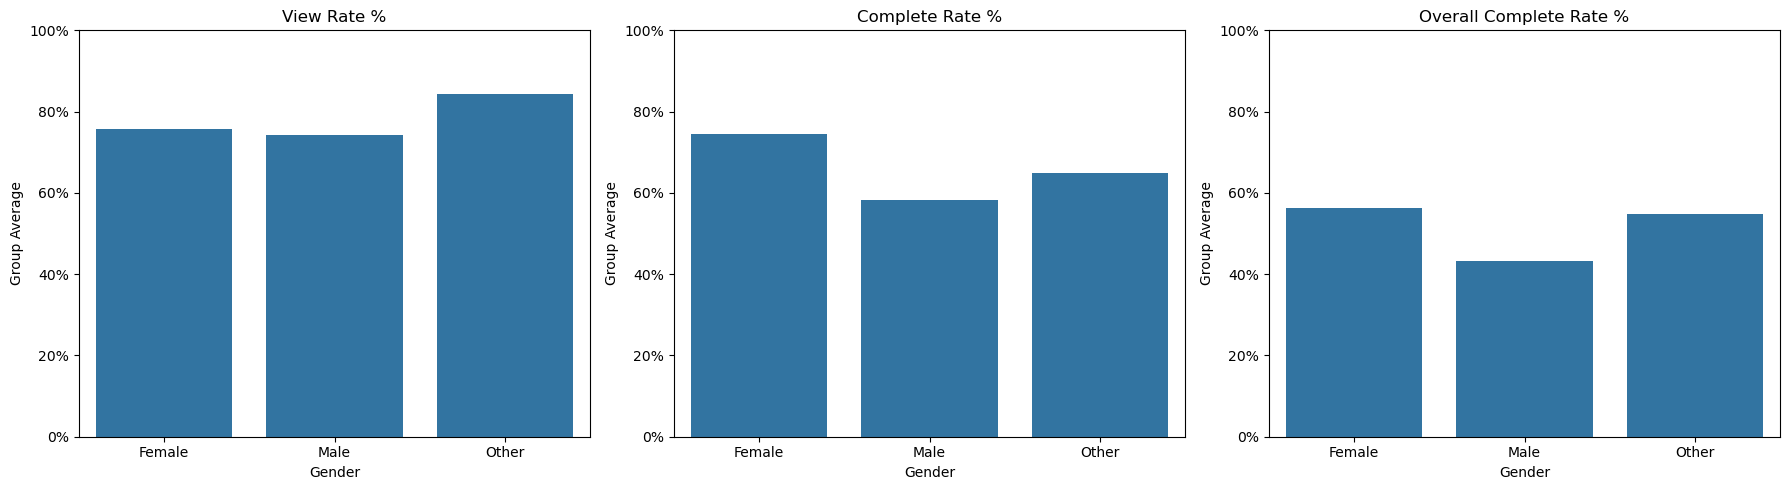

In [309]:
# Group data
grouped_by_gender = event_offer_customer.groupby(['gender', 'event']).agg({'hours_since_start': 'count'})
gender_list = ['F', 'M', 'O']

# Calculate view rate
view_rate = []
for i in range(len(gender_list)):
    view_rate.append(grouped_by_gender.loc[(gender_list[i], 'offer viewed')] / grouped_by_gender.loc[(gender_list[i], 'offer received')])
view_rate = [x[0] for x in view_rate]

# Calculate complete rate
complete_rate = []
for i in range(len(gender_list)):
    complete_rate.append(grouped_by_gender.loc[(gender_list[i], 'offer completed')] / grouped_by_gender.loc[(gender_list[i], 'offer viewed')])
complete_rate = [x[0] for x in complete_rate]

# Calculate overall complete rate
overall_complete_rate = []
for i in range(len(gender_list)):
    overall_complete_rate.append(grouped_by_gender.loc[(gender_list[i], 'offer completed')] / grouped_by_gender.loc[(gender_list[i], 'offer received')])
overall_complete_rate = [x[0] for x in overall_complete_rate]

# Visualize
xticks = np.arange(len(gender_list))
xticklabels = ['Female', 'Male', 'Other']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, 3, figsize = (18, 5))
sns.barplot(x = xticks, y = view_rate, ax = axs[0])
sns.barplot(x = xticks, y = complete_rate, ax = axs[1])
sns.barplot(x = xticks, y = overall_complete_rate, ax = axs[2])
axs[0].set_title('View Rate %'); axs[0].set_xlabel('Gender'); axs[0].set_ylabel('Group Average')
axs[0].set_xticklabels(xticklabels); axs[0].set_yticks(yticks); axs[0].set_yticklabels(ytick_labels)
axs[1].set_title('Complete Rate %'); axs[1].set_xlabel('Gender'); axs[1].set_ylabel('Group Average')
axs[1].set_xticklabels(xticklabels); axs[1].set_yticks(yticks); axs[1].set_yticklabels(ytick_labels)
axs[2].set_title('Overall Complete Rate %'); axs[2].set_xlabel('Gender'); axs[2].set_ylabel('Group Average')
axs[2].set_xticklabels(xticklabels); axs[2].set_yticks(yticks); axs[2].set_yticklabels(ytick_labels)

plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\203347607.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_age = event_offer_customer.groupby(['age_group', 'event']).agg({'hours_since_start': 'count'})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\203347607.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  view_rate = [x[0] for x in view_rate]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\203347607.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

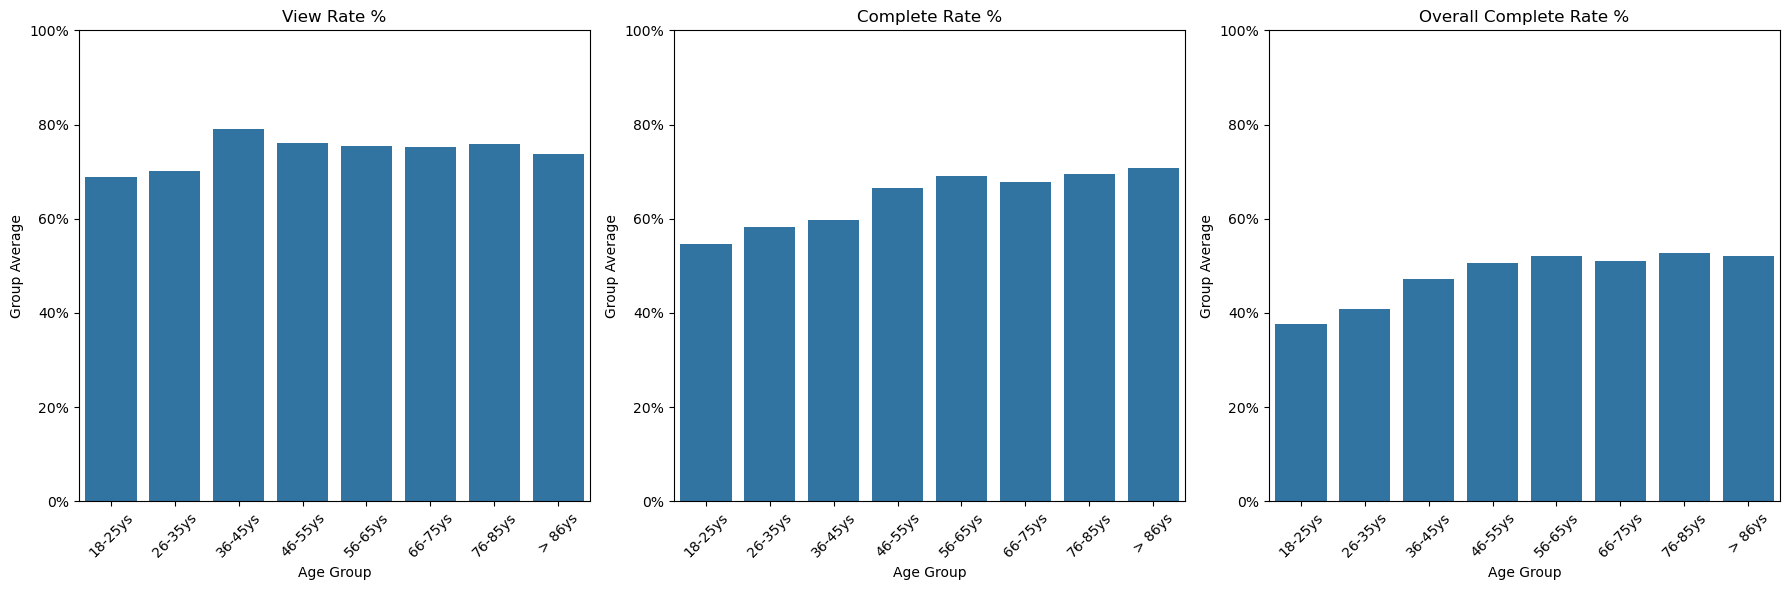

In [310]:
grouped_by_age = event_offer_customer.groupby(['age_group', 'event']).agg({'hours_since_start': 'count'})
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']

# Calculate view rate
view_rate = []
for i in range(len(age_group_list)):
    view_rate.append(grouped_by_age.loc[(age_group_list[i], 'offer viewed')] / grouped_by_age.loc[(age_group_list[i], 'offer received')])
view_rate = [x[0] for x in view_rate]

# Calculate complete rate
complete_rate = []
for i in range(len(age_group_list)):
    complete_rate.append(grouped_by_age.loc[(age_group_list[i], 'offer completed')] / grouped_by_age.loc[(age_group_list[i], 'offer viewed')])
complete_rate = [x[0] for x in complete_rate]

# Calculate overall complete rate
overall_complete_rate = []
for i in range(len(age_group_list)):
    overall_complete_rate.append(grouped_by_age.loc[(age_group_list[i], 'offer completed')] / grouped_by_age.loc[(age_group_list[i], 'offer received')])
overall_complete_rate = [x[0] for x in overall_complete_rate]

# Visualize
xticks = np.arange(len(age_group_list))
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, 3, figsize = (18, 6))
sns.barplot(x = np.arange(len(age_group_list)), y = view_rate, ax = axs[0])
sns.barplot(x = np.arange(len(age_group_list)), y = complete_rate, ax = axs[1])
sns.barplot(x = np.arange(len(age_group_list)), y = overall_complete_rate, ax = axs[2])
axs[0].set_title('View Rate %'); axs[0].set_xlabel('Age Group'); axs[0].set_ylabel('Group Average')
axs[0].set_xticklabels(age_group_list, rotation=45); axs[0].set_yticks(yticks); axs[0].set_yticklabels(ytick_labels)
axs[1].set_title('Complete Rate %'); axs[1].set_xlabel('Age Group'); axs[1].set_ylabel('Group Average')
axs[1].set_xticklabels(age_group_list, rotation=45); axs[1].set_yticks(yticks); axs[1].set_yticklabels(ytick_labels)
axs[2].set_title('Overall Complete Rate %'); axs[2].set_xlabel('Age Group'); axs[2].set_ylabel('Group Average')
axs[2].set_xticklabels(age_group_list, rotation=45); axs[2].set_yticks(yticks); axs[2].set_yticklabels(ytick_labels)

plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\865858629.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_age = event_offer_customer.groupby(['age_group', 'event','channel_alias']).agg({'hours_since_start': 'count'})


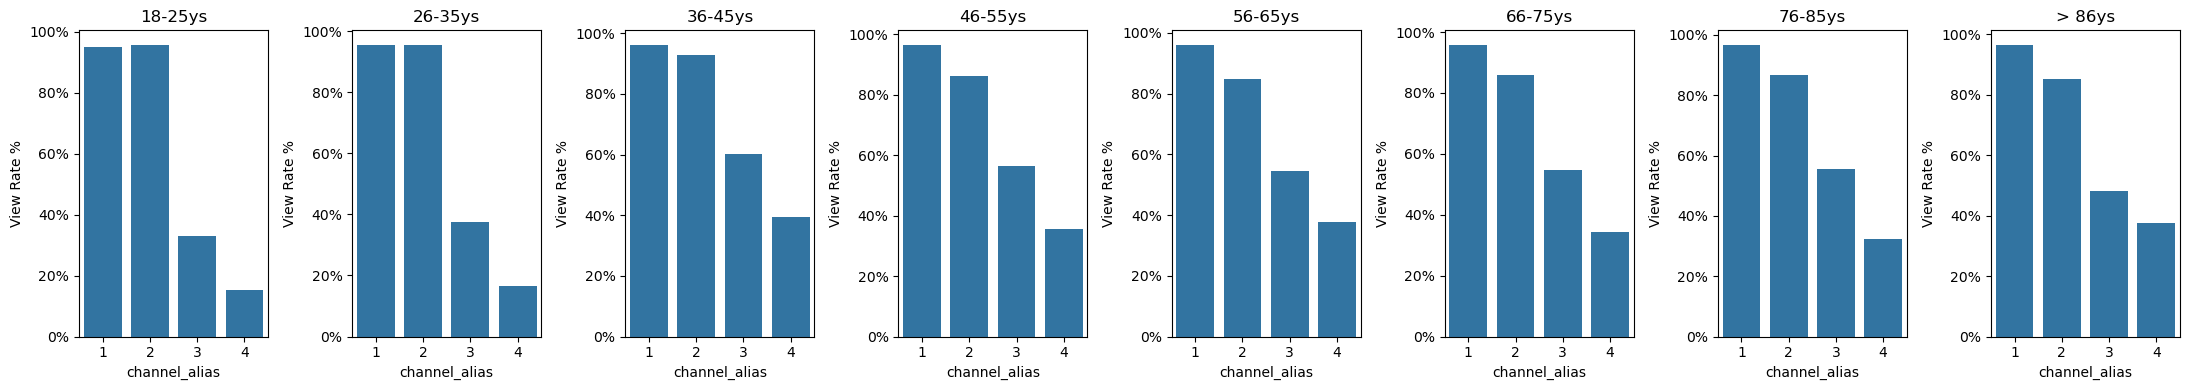

In [311]:
grouped_by_age = event_offer_customer.groupby(['age_group', 'event','channel_alias']).agg({'hours_since_start': 'count'})

# Visualize
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(age_group_list), figsize = (22,4))
for i in range(len(age_group_list)):
    p = (grouped_by_age.loc[(age_group_list[i], 'offer viewed')] / grouped_by_age.loc[(age_group_list[i], 'offer received')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p, x = 'channel_alias', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(age_group_list[i])
    axs[i].set_ylabel('View Rate %')
    
plt.tight_layout()
plt.show()

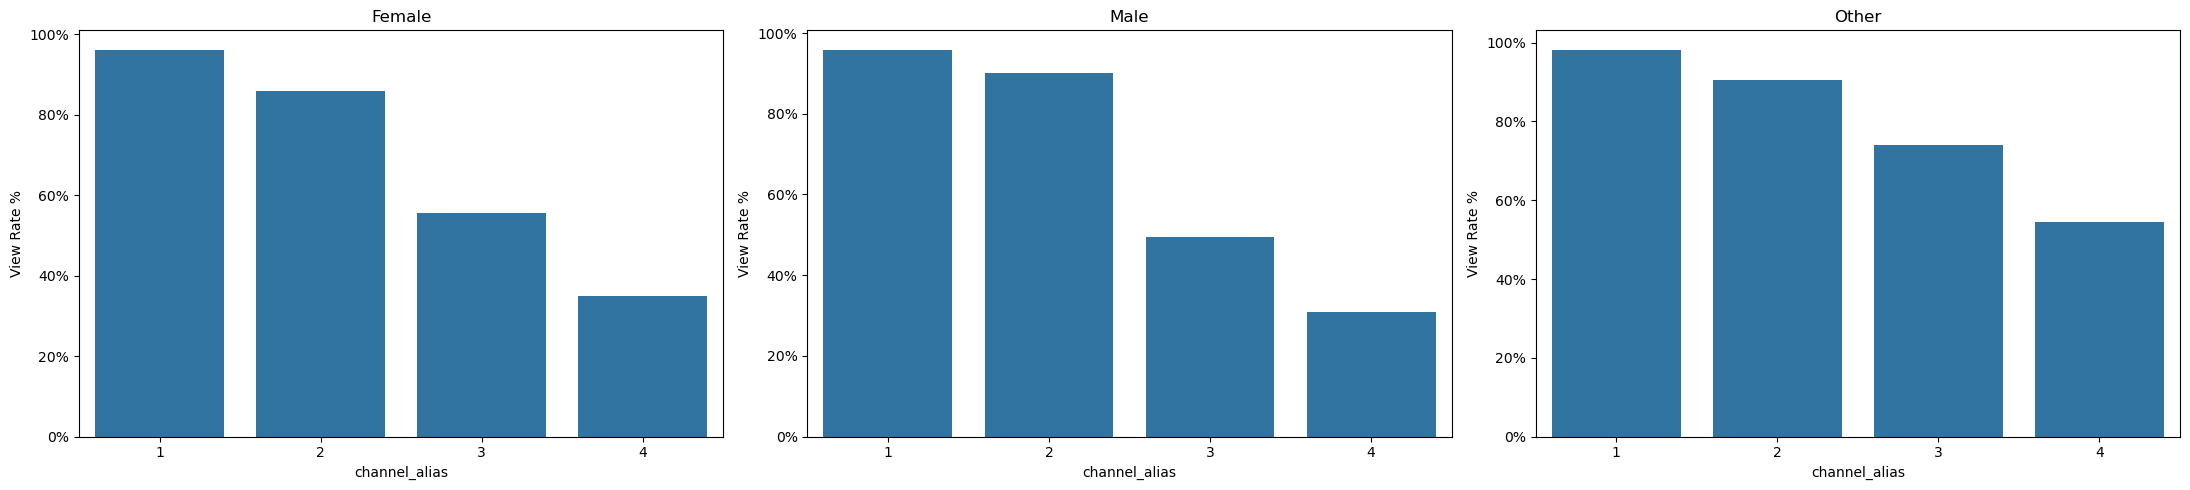

In [312]:
# Group data
grouped_by_gender = event_offer_customer.groupby(['gender', 'event','channel_alias']).agg({'hours_since_start': 'count'})

# Visualize
gender_list = ['F', 'M', 'O']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]
title_list = ['Female', 'Male', 'Other']

fig, axs = plt.subplots(1, len(gender_list), figsize = (22,5))
for i in range(len(gender_list)):
    p = (grouped_by_gender.loc[(gender_list[i], 'offer viewed')] / grouped_by_gender.loc[(gender_list[i], 'offer received')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p, x = 'channel_alias', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(title_list[i])
    axs[i].set_ylabel('View Rate %')
    
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\2233402629.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_income = event_offer_customer.groupby(['income_group', 'event','channel_alias']).agg({'hours_since_start': 'count'})


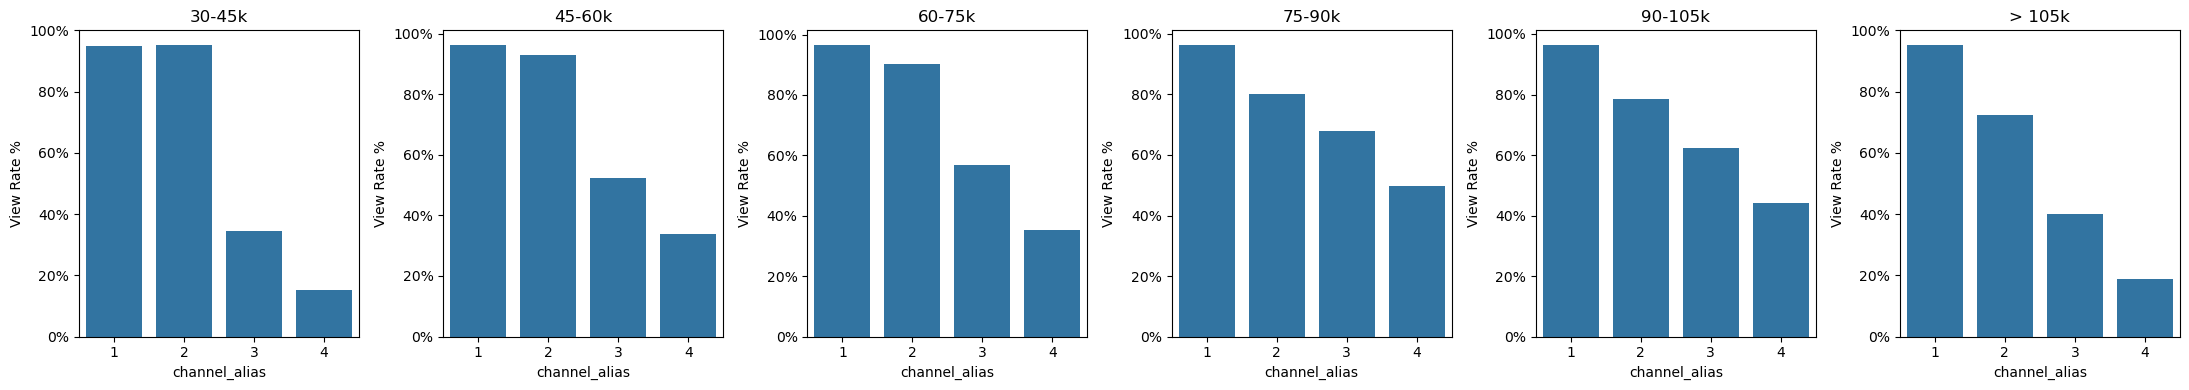

In [313]:
# Group data
grouped_by_income = event_offer_customer.groupby(['income_group', 'event','channel_alias']).agg({'hours_since_start': 'count'})

# Visualize
income_group_list = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(income_group_list), figsize = (22,4))
for i in range(len(income_group_list)):
    p = (grouped_by_income.loc[(income_group_list[i], 'offer viewed')] / grouped_by_income.loc[(income_group_list[i], 'offer received')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p, x = 'channel_alias', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(income_group_list[i])
    axs[i].set_ylabel('View Rate %')
    
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\2232209521.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_age = event_offer_customer.groupby(['age_group', 'event','offer_type']).agg({'hours_since_start': 'count'})


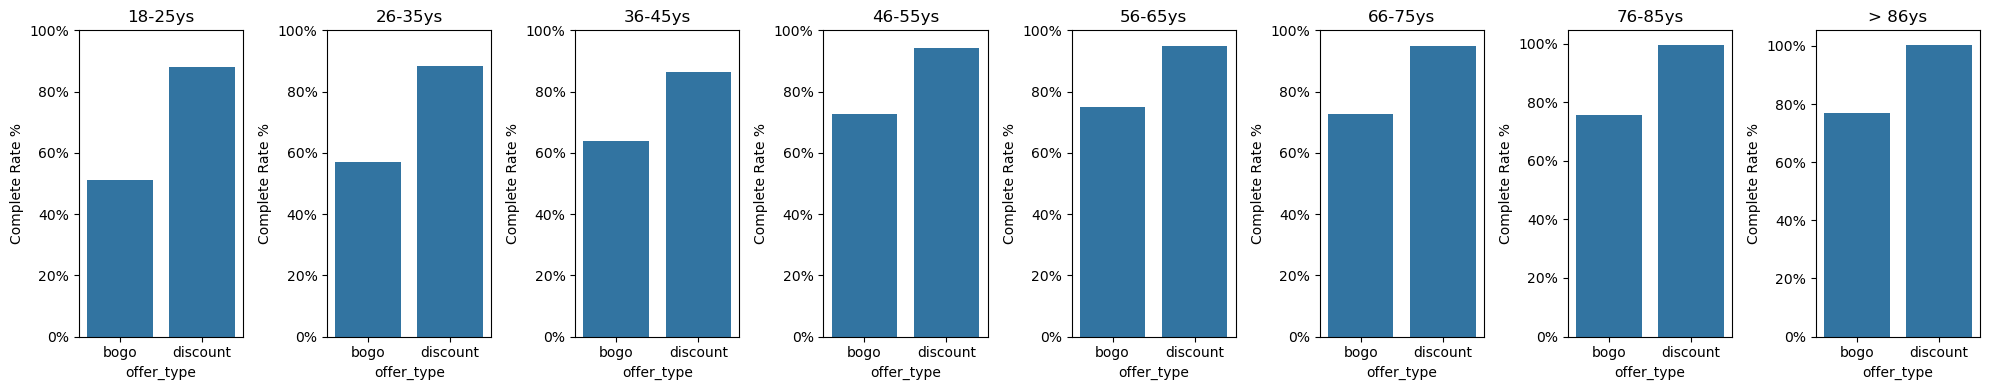

In [314]:
grouped_by_age = event_offer_customer.groupby(['age_group', 'event','offer_type']).agg({'hours_since_start': 'count'})

# Visualize
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(age_group_list), figsize = (20,4))
for i in range(len(age_group_list)):
    p = (grouped_by_age.loc[(age_group_list[i], 'offer completed')] / grouped_by_age.loc[(age_group_list[i], 'offer viewed')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p.iloc[0:2,:], x = 'offer_type', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(age_group_list[i])
    axs[i].set_ylabel('Complete Rate %')
    
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5248\1484973910.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_income = event_offer_customer.groupby(['income_group', 'event','offer_type']).agg({'hours_since_start': 'count'})


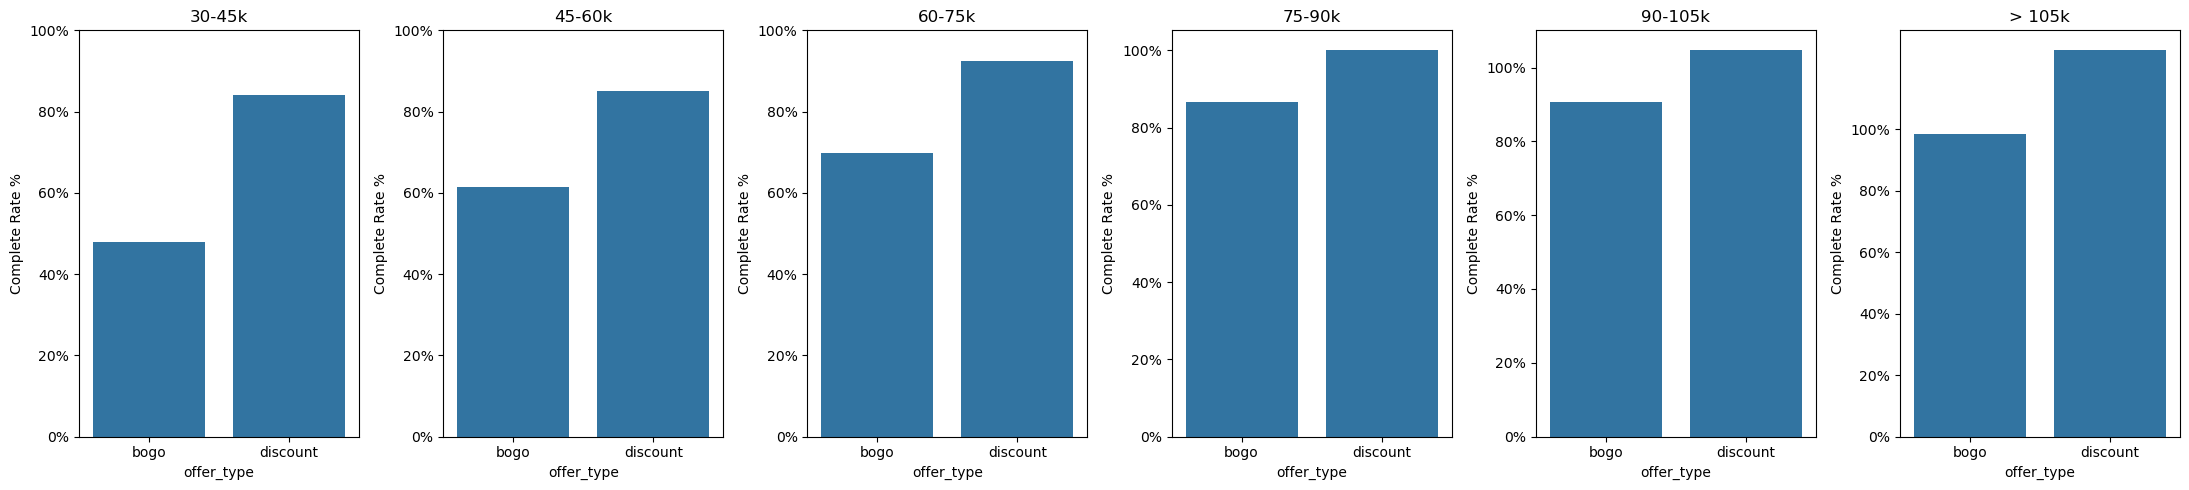

In [315]:
grouped_by_income = event_offer_customer.groupby(['income_group', 'event','offer_type']).agg({'hours_since_start': 'count'})

# Visualize
income_group_list = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(income_group_list), figsize = (22,5))
for i in range(len(income_group_list)):
    p = (grouped_by_income.loc[(income_group_list[i], 'offer completed')] / grouped_by_income.loc[(income_group_list[i], 'offer viewed')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p.iloc[0:2,:], x = 'offer_type', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(income_group_list[i])
    axs[i].set_ylabel('Complete Rate %')
    
plt.tight_layout()
plt.show()

# ***Results***
***1. Customer Demographics***
***Gender Distribution***:  
Males: 57.2%  
Females: 41.3%  
Other Genders: 1.4%  
***Age***:  
Range: 18 to 101 years  
Mean Age: 54 years  
Age Groups (46-75 years): 60% of customers  

***Income***:  
Range: 30k to 120k USD  
Mean Income: 65.4k USD  
Major Income Bracket: 45k-75k USD  

***Average Income by Age Group***:  
18-35 years: ~51k USD  
36-55 years: ~65k USD  
56+ years: ~70k USD  

***Gender & Income***: Males are generally younger and have a lower average income compared to other genders.  

***2. Transactional Activities***  
***Total Transactions***: Approximately 140k purchases (many without offers).  
***Offers***:  
Total Received: 76k  
Viewed: 76% of received offers  
Completed: 44% of viewed offers  

***Completion Peaks***:  
Occurred on the same day offers were sent.  
Short-lived boost in transactions observed post-completion peaks.  

***3. Offer Popularity***  

***Overall Completion Rate***:  

***Top Offers***:  
F: 70%  
E: 67.4%  
B: 56.7%  

***View Rate***:  

***Most Effective Channels***: Social Media > Email >= Mobile > Websites  

***Completion Rate***:  

***Best Performing Offer Type***: 'Discount' offers Longer offer durations generally improve completion rates.  

***4. Customer Segmentation***  
***Segments***:  
***Most Valuable Customers (16.3%):*** These are the top customers who shop frequently and spend a lot of money. They are also fairly responsive to promotional offers. The company should focus on keeping these customers happy by offering them exclusive deals and rewards to encourage even more purchases.  
***Regulars (27.4%):*** These customers shop regularly but spend less per transaction. They are moderately responsive to offers. The strategy here should be to encourage them to spend more by suggesting additional products or special promotions.  
***High-Potentials (13.6%):*** These customers make a lot of purchases but spend less per purchase. They are not very responsive to offers right now, but with targeted promotions, they could become high-value customers. The goal is to increase their spending by offering more appealing deals.  
***Offer-Viewers (23.5%):*** These customers look at offers often but don’t buy much. They are not very sensitive to offers. The approach should be to make the offers more enticing to convert their interest into actual purchases.  
***Low-Engagers (19.2%):*** These customers are the least engaged, shopping infrequently and spending the least. They also don’t respond much to offers. Efforts should be made to understand their needs better and provide targeted incentives to increase their engagement.alue than the Low-Engagers (6.9 USD).